In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
# deviceの作成
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [3]:
device

'cuda'

In [4]:
# Google Driveをマウントする
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# bricks フォルダにはtrainとvalフォルダがある
!ls /content/drive/'My Drive'/bricks

train  val


In [6]:
# さらにtrainフォルダにはレンガ種別ごとのフォルダがある
!ls /content/drive/'My Drive'/bricks/train

australia-brick  hanmasu-red-brick  normal-red-brick
basic-brick	 hanpen-red-brick   saboten-brick


In [7]:
# transform作成
transform = transforms.Compose([
    # ランダムに水平反転
    transforms.RandomHorizontalFlip(),
    # ランダムに明るさ、コントラスト、彩度、色相変化
    transforms.ColorJitter(),
    # ランダムに画像を回転(+-10度)
    transforms.RandomRotation(10),
    # 画像を224x224にリサイズ
    transforms.Resize((224,224)),
    # テンソル変換
    transforms.ToTensor(),
    # Normalize(平均0.5, 標準偏差0.5), 3チャネルに対して行う
    transforms.Normalize((0.5,),(0.5,))
])

# 評価用のtransformはデータ拡張は行わない
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


In [8]:
# ImageFolderで指定したフォルダごとにラベルを作成してくれる
train_dataset = datasets.ImageFolder("/content/drive/My Drive/bricks/train", transform=transform)
validation_dataset = datasets.ImageFolder("/content/drive/My Drive/bricks/val", transform=val_transform)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [10]:
data_iter = iter(train_loader)

In [11]:
imgs, labels = data_iter.next()
labels

tensor([4, 2, 4, 3, 3, 0, 2, 2, 3, 2, 2, 0, 0, 4, 1, 2, 1, 4, 1, 2, 2, 2, 0, 0,
        0, 0, 4, 0, 2, 0, 4, 2])

In [12]:
# labels_name_list = ['australia-brick', 'basic-brick', 'hanmasu-red-brick', 'hanpen-red-brick', 'normal-red-brick', 'saboten-brick']
# labels_name = [labels_name_list[int(label)] for label in labels]
# labels_name

In [13]:
# (バッチサイズ, channel数, h, w)
imgs.size()

torch.Size([32, 3, 224, 224])

In [14]:
img = imgs[14]
img.size()

torch.Size([3, 224, 224])

In [15]:
# channel lastにする
img_permute = img.permute(1,2,0)
img_permute.size()

torch.Size([224, 224, 3])

In [16]:
# 画像を明るくする
img_permute = 0.5 * img_permute + 0.5

In [17]:
# 0-1の間におさめる
img_permute = np.clip(img_permute, 0, 1)
img_permute

tensor([[[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0431, 0.0471, 0.0510],
         ...,
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0431, 0.0471, 0.0510],
         ...,
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0471, 0.0510, 0.0588],
         ...,
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        ...,

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         ...,
         [0.1882, 0.1451, 0.0941],
         [0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000],
         [0.

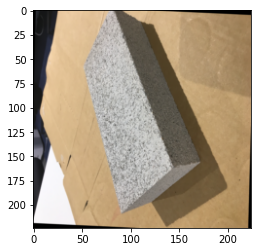

In [18]:
plt.imshow(img_permute)

In [19]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            # 畳み込み層(入力チャンネル3, 出力チャンネル64, 5*5フィルタ, パディング2マスずつ)
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            # 活性化関数ReLU
            nn.ReLU(inplace=True),
            # プーリング層(2*2の範囲で最大値を抽出)
            # h*wが224*224から112*112になる
            nn.MaxPool2d(kernel_size=2),

            # 畳み込み層(入力チャンネル64, 出力チャンネル128, 3*3フィルタ, パディング1マスずつ)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            # 活性化関数ReLU
            nn.ReLU(inplace=True),
            # プーリング層(2*2の範囲で最大値を抽出)
            # h*wが112*112から56*56になる
            nn.MaxPool2d(kernel_size=2),

            # 畳み込み層(入力チャンネル128, 出力チャンネル256, 3*3フィルタ, パディング1マスずつ)
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            # 活性化関数ReLU
            nn.ReLU(inplace=True),
            # プーリング層(2*2の範囲で最大値を抽出)
            # h*wが56*56から28*28になる
            nn.MaxPool2d(kernel_size=2),

            # 畳み込み層(入力チャンネル256, 出力チャンネル128, 3*3フィルタ, パディング1マスずつ)
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            # 活性化関数ReLU
            nn.ReLU(inplace=True),
        )
        # 全結合層
        self.classifier = nn.Linear(in_features=28*28*128, out_features=num_classes)
    def forward(self, x):
        # 出力のサイズは(バッチ数32, h28, w28, channel数128)
        x = self.features(x)
        # 1次元のベクトル化を行う(x.size(0)=バッチ数32, 残り全部=28*28*128)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [20]:
model = CNN(6)
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=100352, out_features=6, bias=True)
)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [22]:
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
# 画像表示用に取得する
disp_val_imgs = []
disp_val_labels = []
disp_val_preds = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_loader:
        # gpuデバイスに送る
        imgs = imgs.to(device)
        labels = labels.to(device)
        # 勾配を初期化
        optimizer.zero_grad()
        output = model(imgs)
        # 損失計算
        loss = criterion(output, labels)
        # 逆伝播
        loss.backward()
        running_loss += loss.item()
        # outputのうちの最大のものが予測結果になる
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        # 勾配計算の最適化
        optimizer.step()
    running_loss /= len(train_loader)
    running_acc /= len(train_loader)
    losses.append(running_loss)
    accs.append(running_acc)
    #
    # validation loop
    #
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_loader:        
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
        # 最後のepochのときだけ画像表示用に取得する
        if epoch == num_epochs - 1:
            disp_val_imgs.append(val_imgs)
            disp_val_labels.append(val_labels)
            disp_val_preds.append(val_pred)
    val_running_loss /= len(validation_loader)
    val_running_acc /= len(validation_loader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print(f'epoch: {epoch}, loss: {running_loss}, acc: {running_acc}, val_loss: {val_running_loss}, val_acc: {val_running_acc}')

epoch: 0, loss: 1.5488756412551516, acc: 0.380952388048172, val_loss: 1.5316809713840485, val_acc: 0.4955357313156128
epoch: 1, loss: 0.8383373007887885, acc: 0.680059552192688, val_loss: 0.507307693362236, val_acc: 0.8526785969734192
epoch: 2, loss: 0.5333719714766457, acc: 0.7842261791229248, val_loss: 0.7614803165197372, val_acc: 0.6741071939468384
epoch: 3, loss: 0.48572563347572995, acc: 0.8288690447807312, val_loss: 0.5637340843677521, val_acc: 0.8058035969734192
epoch: 4, loss: 0.4004235217968623, acc: 0.836309552192688, val_loss: 0.4111594185233116, val_acc: 0.828125
epoch: 5, loss: 0.6666473952077684, acc: 0.8080357313156128, val_loss: 0.6686719283461571, val_acc: 0.8102678656578064
epoch: 6, loss: 0.3773575803082037, acc: 0.8630952835083008, val_loss: 0.4538929909467697, val_acc: 0.7723214626312256
epoch: 7, loss: 0.22538321223830626, acc: 0.90625, val_loss: 0.28264933824539185, val_acc: 0.8794642686843872
epoch: 8, loss: 0.1300553608951824, acc: 0.9568452835083008, val_loss:

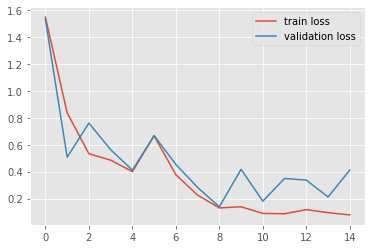

In [23]:
plt.style.use('ggplot')
plt.plot(losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

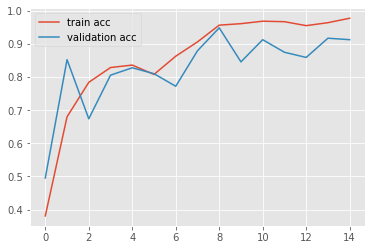

In [24]:
plt.plot(accs, label='train acc')
plt.plot(val_accs, label='validation acc')
plt.legend()

In [26]:
torch.save(model.state_dict(), "model_cnn.pth")